# Dr. Frank's 2020 Election Analysis for Ohio -- Generate `Key`

Based on Robert Lee's Python code from [his github repo](https://github.com/rlee32/election-fraud-ohio).

efg, 2022-03-26

Assumes setup script already run:  `Ohio-Analysis-1-Setup.ipynb`

*Generate conversion key that helps us predict the number of votes based* on Robert Lee's `generate_key.py` script.

*Looks at all available counties and computes a conversion key that can be used to predict actual turnout from registrations.*

In [1]:
import datetime
start_time = datetime.datetime.now()
print (start_time)

2022-03-27 00:56:12.251128


In [2]:
import os
import sys
import json

import pandas as pd

from matplotlib import pyplot as plt   
%matplotlib inline

Ohio County codes

In [3]:
OhioCounty = pd.read_csv("Ohio-Codes.csv")
print(OhioCounty)

    Code      County
0      1       Adams
1      2       Allen
2      3     Ashland
3      4   Ashtabula
4      5      Athens
..   ...         ...
83    84  Washington
84    85       Wayne
85    86    Williams
86    87        Wood
87    88     Wyandot

[88 rows x 2 columns]


In [4]:
OhioCounty.dtypes

Code       int64
County    object
dtype: object

# 1. Setup

Adapted from script `plot_turnout_by_age.py`

In [5]:
TOTAL_COUNTIES = 88  
JSON_FOLDER    = './jsonified/' 
OUTPUT_FILE    = './key.json'

In [6]:
ELECTION_YEAR = 2020 # choose presidential election years from 2000 - 2020

ELECTION_DAY = {
    2020: '03',
    2016: '08',
    2012: '06',
    2008: '04',
    2004: '02',
    2000: '07'
}

ELECTION_DATE = f'{ELECTION_YEAR}-11-{ELECTION_DAY[ELECTION_YEAR]}'
ELECTION_FIELD = f'general_{ELECTION_YEAR}'      

In [7]:
ELECTION_DATE

'2020-11-03'

In [8]:
ELECTION_FIELD

'general_2020'

## 1.1 "Helper" functions

In [9]:
def str_to_int(date):
    """Converts date in form YYYY-MM-DD to and integer of form YYYYMMDD. """
    return int(date.replace('-', ''))   

In [10]:
def get_age(start_date, end_date):
    """Returns integer age given dates in form YYYY-MM-DD. """
    start = str_to_int(start_date)
    end = str_to_int(end_date)
    diff = end - start
    if diff < 0:
        return diff / 10000.0
    else:
        return int(diff / 10000)         

In [11]:
def votes_by_age(county_id: int):
    """Reads voter data in json format and outputs votes aggregated by age for the specified election. """
    data = json.load(open(f'{JSON_FOLDER}/{county_id}.json', 'r'))
    by_age = {}
    for d in data:
        registration_age = get_age(d['registration_date'], ELECTION_DATE)
        if registration_age < 0:
            continue
            
        age = get_age(d['date_of_birth'], ELECTION_DATE)
        if age < 18:
            print(f'skipping underage {age}; data: {d}')
            continue
            
        if age > 105:    # lower this from 150 to 105
            print(f'skipping unreasonable age {age}; data: {d}')
            continue
            
        if age not in by_age:
            by_age[age] = {'registered': 0, 'voted': 0, 'active': 0}
            
        by_age[age]['registered'] += 1
        
        if d["voter_status"] == "ACTIVE":   
            by_age[age]['active'] += 1
            
        if d[ELECTION_FIELD].strip():
            by_age[age]['voted'] += 1
    return by_age                         

# 2. Generate `Key`

In [12]:
filenames = os.listdir(JSON_FOLDER)
len(filenames)

88

In [13]:
MINIMUM_TOTAL_VOTERS = None # per county
counties_used = 0
turnouts      = {} # maps age to a list of conversion key (normalized turnout) values.

In [14]:
for f in filenames:
    if f[-5:] != '.json':
        continue
    try:
        county_id = int(f.split('.')[0])
        
        by_age = votes_by_age(county_id)
        
        sorted_by_age = list(by_age.items())
        sorted_by_age.sort()
        
        age        = [x[0]                    for x in sorted_by_age]
        registered = [by_age[x]['registered'] for x in age]
        voted      = [by_age[x]['voted']      for x in age]
       
        
        overall_turnout = sum(voted) / sum(registered)        
        print(f'county {county_id} has {sum(registered)} registered voters')
        if MINIMUM_TOTAL_VOTERS is not None and sum(registered) < MINIMUM_TOTAL_VOTERS:
            continue
        ii = range(len(registered))
        key = [voted[i] / registered[i] / overall_turnout for i in ii]
        
        for i in ii:
            a = age[i]
            if a not in turnouts:
                turnouts[a] = []
            turnouts[a].append(key[i])
            
        counties_used += 1
    except Exception as e:
        print(f'could not use county_id {county_id}')
        print(e)                                   

skipping unreasonable age 106; data: {'date_of_birth': '1914-10-10', 'registration_date': '2011-10-09', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 119; data: {'date_of_birth': '1901-01-01', 'registration_date': '2019-03-04', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2002-11-08', 'registration_date': '2020-06-02', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 119; data: {'date_of_birth': '1901-01-01', 'registration_date': '2020-11-03', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'gene

skipping unreasonable age 106; data: {'date_of_birth': '1914-10-09', 'registration_date': '1900-01-01', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '2013-02-01', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 107; data: {'date_of_birth': '1912-12-07', 'registration_date': '2015-10-05', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': 'X', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 116; data: {'date_of_birth': '1903-12-22', 'registration_date': '1954-04-23', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'ge

skipping underage 17; data: {'date_of_birth': '2002-11-04', 'registration_date': '2020-10-09', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2003-03-27', 'registration_date': '2020-10-01', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2002-12-06', 'registration_date': '2002-12-16', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2002-12-07', 'registration_date': '2020-03-04', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'

county 21 has 142913 registered voters
county 22 has 50961 registered voters
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1959-09-14', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1948-10-04', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping underage 17; data: {'date_of_birth': '2003-03-05', 'registration_date': '2020-03-05', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1968-09-24', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general

skipping underage 17; data: {'date_of_birth': '2003-08-28', 'registration_date': '2020-09-20', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1977-01-01', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 114; data: {'date_of_birth': '1906-08-15', 'registration_date': '1977-01-01', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1977-01-01', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'ge

skipping unreasonable age 119; data: {'date_of_birth': '1900-11-04', 'registration_date': '2008-12-09', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1977-01-01', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 109; data: {'date_of_birth': '1911-01-01', 'registration_date': '2011-05-09', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': '', 'general_2008': '', 'general_2012': 'X'}
skipping unreasonable age 106; data: {'date_of_birth': '1914-08-09', 'registration_date': '2015-07-10', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': 'X', 'general_2004': '', 'general_2008': '', 'ge

skipping unreasonable age 113; data: {'date_of_birth': '1906-12-30', 'registration_date': '1992-08-20', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 120; data: {'date_of_birth': '1900-01-18', 'registration_date': '2020-04-28', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '2016-10-11', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '2016-10-10', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': 'X', 'general_2020': '', 'general_2004': '', 'general_2008': '', '

county 30 has 23124 registered voters
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'gener

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'gen

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', '

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'g

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1989-07-17', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general

county 31 has 566572 registered voters
skipping underage 17; data: {'date_of_birth': '2003-04-14', 'registration_date': '2015-06-15', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2002-11-07', 'registration_date': '2019-10-23', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2002-12-12', 'registration_date': '2001-04-01', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
county 32 has 46833 registered voters
county 33 has 16904 registered voters
county 34 has 9563 registered voters
skipping underage 17; data: {'date_of_birth': '2003-02-18', 'registration_date': '2020-09-18', 'voter_status': 'ACTIVE'

county 40 has 19818 registered voters
skipping unreasonable age 120; data: {'date_of_birth': '1900-01-01', 'registration_date': '1967-05-24', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 120; data: {'date_of_birth': '1900-01-01', 'registration_date': '1968-08-15', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 120; data: {'date_of_birth': '1900-01-01', 'registration_date': '1967-05-18', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 120; data: {'date_of_birth': '1900-01-01', 'registration_date': '1967-05-18', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X

county 42 has 39456 registered voters
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1966-09-27', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 106; data: {'date_of_birth': '1914-09-22', 'registration_date': '2013-07-15', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1968-03-26', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping underage 17; data: {'date_of_birth': '2003-03-11', 'registration_date': '2020-09-22', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1955-09-24', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1970-09-22', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1950-09-25', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1956-09-26', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_20

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1960-09-26', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2003-03-31', 'registration_date': '2020-05-21', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1964-09-12', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1971-09-22', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'g

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1955-03-23', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1962-09-25', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1963-03-25', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1960-09-27', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_20

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1980-10-17', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 120; data: {'date_of_birth': '1900-08-04', 'registration_date': '2010-06-22', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 112; data: {'date_of_birth': '1908-07-22', 'registration_date': '2008-08-11', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': '', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1980-10-17', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': '

skipping underage 17; data: {'date_of_birth': '2003-07-08', 'registration_date': '2020-09-30', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 120; data: {'date_of_birth': '1900-01-01', 'registration_date': '2018-09-18', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2003-02-25', 'registration_date': '2020-09-30', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 120; data: {'date_of_birth': '1900-01-01', 'registration_date': '2019-12-13', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skippi

county 57 has 349640 registered voters
skipping unreasonable age 116; data: {'date_of_birth': '1904-03-26', 'registration_date': '2004-09-28', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': '', 'general_2008': 'X', 'general_2012': 'X'}
county 58 has 8690 registered voters
skipping unreasonable age 110; data: {'date_of_birth': '1910-05-14', 'registration_date': '1982-01-14', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 107; data: {'date_of_birth': '1912-11-29', 'registration_date': '1989-10-10', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
county 59 has 22858 registered voters
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1997-11-04', 'voter_status':

skipping underage 17; data: {'date_of_birth': '2003-07-02', 'registration_date': '2020-09-10', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
county 67 has 101309 registered voters
skipping underage 17; data: {'date_of_birth': '2002-12-13', 'registration_date': '2020-04-02', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
county 68 has 26917 registered voters
county 69 has 22756 registered voters
skipping unreasonable age 119; data: {'date_of_birth': '1901-01-01', 'registration_date': '2004-10-04', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 106; data: {'date_of_birth': '1914-07-10', 'registration_date': '1977-11-08', 'voter_status': 'ACTIVE', 'general_2000': '

skipping underage 17; data: {'date_of_birth': '2003-05-24', 'registration_date': '2020-10-21', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 120; data: {'date_of_birth': '1900-01-01', 'registration_date': '1950-09-27', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': ''}
skipping unreasonable age 120; data: {'date_of_birth': '1900-01-01', 'registration_date': '2020-11-03', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': 'X', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
county 71 has 43712 registered voters
skipping unreasonable age 120; data: {'date_of_birth': '1900-01-01', 'registration_date': '2016-11-30', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': 'X', 'general_2020': '', 'general

county 76 has 222304 registered voters
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1968-09-10', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1965-07-27', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '2019-08-05', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1956-09-26', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_202

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1956-09-12', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1968-09-24', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1968-09-13', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1957-09-23', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', '

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1970-09-21', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1956-09-25', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1967-09-27', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}
county 77 has 353479 registered voters
skipping unreasonable age 120; data: {'date_of_birth': '1900-08-20', 'registration_date': '1963-09-25', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': 'X', 'general_2020': 'X', 'ge

skipping underage 17; data: {'date_of_birth': '2003-01-10', 'registration_date': '2020-10-15', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2003-02-17', 'registration_date': '2020-02-18', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1964-09-23', 'voter_status': 'CONFIRMATION', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2003-04-16', 'registration_date': '2018-05-15', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 

skipping underage 17; data: {'date_of_birth': '2003-03-09', 'registration_date': '2020-10-08', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2003-08-08', 'registration_date': '2020-10-05', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2003-03-10', 'registration_date': '2020-10-05', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_of_birth': '2003-05-21', 'registration_date': '2020-10-16', 'voter_status': 'ACTIVE', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping underage 17; data: {'date_o

In [15]:
print(f'used {counties_used} counties.')

if MINIMUM_TOTAL_VOTERS is not None:
    print(f'skipped counties with less than {MINIMUM_TOTAL_VOTERS} voters.')

# finally, write out key as json.
for age in turnouts:
    counts        = turnouts[age]
    avg           = sum(counts) / len(counts)
    turnouts[age] = avg

json.dump(turnouts, open(OUTPUT_FILE, 'w'))    
print(f'wrote key to {OUTPUT_FILE}')      

used 88 counties.
wrote key to ./key.json


# 3. Plot Key Curve

Must sort ages from `dict`for plotting

In [16]:
key = pd.DataFrame({'age'  : turnouts.keys(),
                    'ratio': turnouts.values()})
key = key.sort_values(by = 'age');

In [17]:
key.tail(20)

,age,ratio
68,86,1.086098
69,87,1.069012
70,88,1.061158
71,89,1.015856
72,90,1.002191
73,91,0.989590
74,92,0.953230
75,93,0.950116
76,94,0.899214
77,95,0.854309


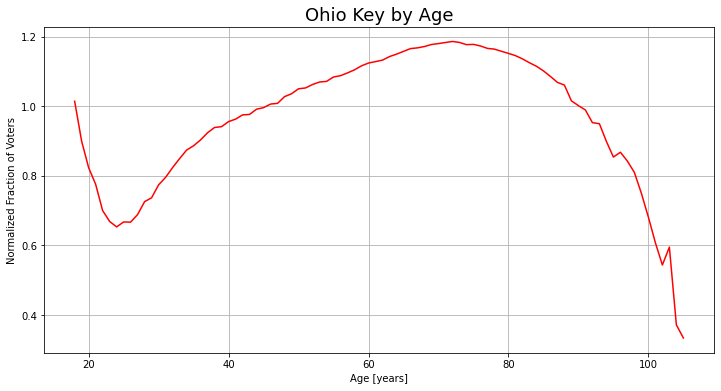

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(key.age, key.ratio,  color ="red",   label = f'Ohio Key)')

ax.set(xlabel = 'Age [years]', ylabel = 'Normalized Fraction of Voters')
ax.set_title(f'Ohio Key by Age', fontsize = 18)

plt.grid()
plt.show()

In [19]:
stop_time = datetime.datetime.now()
print (stop_time)
print ((stop_time - start_time), "elapsed time")

2022-03-27 00:57:01.297799
0:00:49.046671 elapsed time
